피마족 당뇨병 예측 모델을 다층 퍼셉트론 기반으로 만들어보겠습니다. 파일은 아래 링크에서 다운로드 받습니다.

http://aifactory.space/aifactory/taskData/detail.do?task.taskId=T002005

의료 데이터라 생소할 수 있으나, 수치로만 되어 있기 때문에 입문 예제로는 그리 어렵지 않습니다. 먼저 데이터셋부터 살펴보겠습니다.

원본 데이터셋에 대한 스펙은 다음과 같습니다.

* 훈련셋: 700개
    * x_train, y_train
* 시험셋: 68개
    * x_test
* 속성 수: 8개
* 클래스 수: 2개    

8가지 속성의 상세 내용은 다음과 같습니다.

* 임신 횟수
* 경구 포도당 내성 검사에서 2시간 동안의 혈장 포도당 농도
* 이완기 혈압 (mm Hg)
* 삼두근 피부 두겹 두께 (mm)
* 2 시간 혈청 인슐린 (mu U/ml)
* 체질량 지수
* 당뇨 직계 가족력
* 나이 (세)

클래수는 0과 1이며, 이는 "5년 이내 당뇨병이 발병 여부"를 뜻합니다. 0이면 발병안함, 1이면 발병한 것을 의미합니다.

먼저 풀어야 할 시험셋의 샘플 x을 먼저 살펴보겠습니다.

In [1]:
import numpy as np

x_test = np.loadtxt('x_test.csv', delimiter=',')
np.set_printoptions(suppress=True)
print(x_test)

[[  2.    122.     76.     27.    200.     35.9     0.483  26.   ]
 [  6.    125.     78.     31.      0.     27.6     0.565  49.   ]
 [  1.    168.     88.     29.      0.     35.      0.905  52.   ]
 [  2.    129.      0.      0.      0.     38.5     0.304  41.   ]
 [  4.    110.     76.     20.    100.     28.4     0.118  27.   ]
 [  6.     80.     80.     36.      0.     39.8     0.177  28.   ]
 [ 10.    115.      0.      0.      0.      0.      0.261  30.   ]
 [  2.    127.     46.     21.    335.     34.4     0.176  22.   ]
 [  9.    164.     78.      0.      0.     32.8     0.148  45.   ]
 [  2.     93.     64.     32.    160.     38.      0.674  23.   ]
 [  3.    158.     64.     13.    387.     31.2     0.295  24.   ]
 [  5.    126.     78.     27.     22.     29.6     0.439  40.   ]
 [ 10.    129.     62.     36.      0.     41.2     0.441  38.   ]
 [  0.    134.     58.     20.    291.     26.4     0.352  21.   ]
 [  3.    102.     74.      0.      0.     29.5     0.121  32.

68개의 샘플에 대해 8가지 속성을 보고 5년 이내 당뇨병이 발병 여부를 예측하는 문제입니다. 우리는 다층 퍼셉트론 신경망 모델을 훈련셋으로 학습시킨 후 68개의 시험 샘플을 풀어보도록 하겠습니다. 

먼저 훈련셋을 불러옵니다.

In [2]:
x_train = np.loadtxt('x_train.csv', delimiter=',')
y_train = np.loadtxt('y_train.csv', delimiter=',')

훈련셋 속성들의 특성을 알아보기 위해 가시화를 수행합니다. 각 속성마다 컬럼명을 지정한 후 히스토그램 플랏을 띄워봅니다.

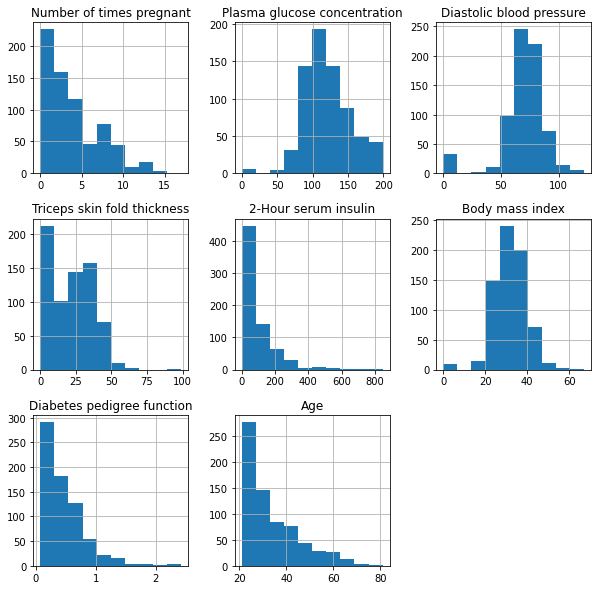

In [3]:
import pandas as pd

df = pd.DataFrame(x_train)

df = df.rename(columns={0: 'Number of times pregnant', 
                                  1: 'Plasma glucose concentration',
                                  2: 'Diastolic blood pressure',
                                  3: 'Triceps skin fold thickness',
                                  4: '2-Hour serum insulin',
                                  5: 'Body mass index',
                                  6: 'Diabetes pedigree function',
                                  7: 'Age'})

histo = df.hist(figsize = [10, 10])

훈련셋의 라벨 통계도 구합니다. 이진 분류이므로 0과 1값별로 카운팅을 해봅니다.

In [4]:
print( (y_train == 0).sum() )
print( (y_train == 1).sum() )

459
241


딥러닝 모델이 잘 학습할 수 있도록 입력 데이터의 전처리를 수행합니다. 속성별로 상이한 스케일을 가진 데이터를 입력하면 스케일이 큰 속성에 영향을 많이 미치는 경우가 발생하기 때문에, 이 경우 정규화 과정을 거치게 됩니다. 속성별로 평균을 구한 뒤, 각 인스턴스에다 평균을 빼고 표준 편차로 나누겠습니다.

시험셋을 입력할 때, 즉 모델을 학습 후에 사용할 때도 동일하게 정규화를 시켜야하므로, 훈련셋에서 구한 평균과 표준 편차를 기억해둡니다.

In [5]:
mean = x_train.mean(axis=0)
x_train -= mean
std = x_train.std(axis=0)
x_train /= std

print(mean)
print(std)

[  3.82714286 120.54142857  68.88        20.38285714  79.88
  31.89128571   0.47601857  33.12428571]
[  3.36199012  32.1858398   19.52675527  16.02076306 115.50752554
   7.94429686   0.33711587  11.77613732]


필요한 패키지를 불러옵니다.

In [6]:
import numpy as np

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model

입력 속성이 8개이고 출력이 1개인 네트워크 아키텍처를 설계합니다. 비선형 문제를 풀 수 있도록 'relu' 활성화 함수를 가진 여러 층으로 구성했습니다. 출력 벡터 1개는 0.0 ~ 1.0 사이의 실수로 출력될 수 있도록 출력층의 활성화 함수는 'sigmoid'로 설정하였습니다.

In [7]:
model = Sequential([
    Dense(32, input_dim=8, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

모델 형태를 가시화 시켜보겠습니다.

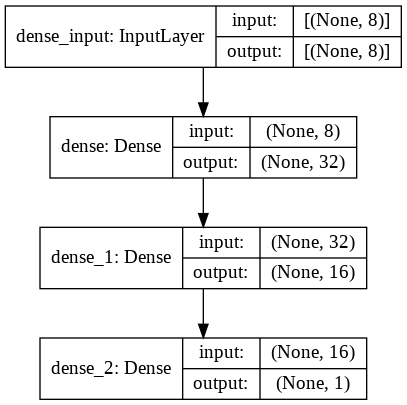

In [8]:
plot_model(model, show_shapes=True)

손실함수는 이진 분류 문제에 'binary_crossentropy'로 설정하고, 최적화기(optimizer)는 'rmsprop'으로 설정하여 모델을 컴파일 합니다. 평가 매트릭은 분류 정확도를 알 수 있도록 'accuracy'로 설정했습니다.

In [9]:
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

콜백함수를 사용하여, 매 에포크마다 검증셋의 손실값을 체크한 후, 이전 손실값보다 낮은 경우 모델을 파일로 저장합니다. 즉 학습 종료가 되면, 파일에 저장된 모델은 손실값이 가장 낮을 때의 가중치를 가지고 있습니다.

모델을 학습시킬 때, validation_split 옵션을 두면 훈련셋 일부를 검증셋으로 설정할 수 있습니다. 0.2로 설정할 경우, 전체 훈련셋에서 20%를 검증셋, 나머지를 훈련셋으로 구성하여 학습합니다.

에포크를 500번으로 배치사이즈를 32개로 두어 학습을 수행합니다.

In [10]:
checkpoint_callback = ModelCheckpoint("best_model.h5", 
                                      save_best_only=True, 
                                      monitor="val_loss")

hist = model.fit(x_train, y_train, 
                 validation_split=0.2, 
                 epochs=500, 
                 batch_size=32, 
                 callbacks=[checkpoint_callback])

Epoch 1/500
18/18 [==============================] - 1s 11ms/step - loss: 0.7019 - accuracy: 0.5500 - val_loss: 0.6444 - val_accuracy: 0.7071
Epoch 2/500
18/18 [==============================] - 0s 2ms/step - loss: 0.6305 - accuracy: 0.6893 - val_loss: 0.5933 - val_accuracy: 0.7929
Epoch 3/500
18/18 [==============================] - 0s 2ms/step - loss: 0.5916 - accuracy: 0.7429 - val_loss: 0.5548 - val_accuracy: 0.7857
Epoch 4/500
18/18 [==============================] - 0s 2ms/step - loss: 0.5624 - accuracy: 0.7536 - val_loss: 0.5239 - val_accuracy: 0.7786
Epoch 5/500
18/18 [==============================] - 0s 2ms/step - loss: 0.5385 - accuracy: 0.7464 - val_loss: 0.4965 - val_accuracy: 0.7786
Epoch 6/500
18/18 [==============================] - 0s 2ms/step - loss: 0.5199 - accuracy: 0.7589 - val_loss: 0.4744 - val_accuracy: 0.7857
Epoch 7/500
18/18 [==============================] - 0s 3ms/step - loss: 0.5056 - accuracy: 0.7571 - val_loss: 0.4581 - val_accuracy: 0.7786
Epoch 8/500


학습 시 매 에포크에 해당하는 훈련셋과 검증셋에 대한 손실값과 평가 메트릭 수치를 확인할 수 있습니다. 이를 시각화시키면 오버피팅 여부를 한 눈에 확인할 수 있습니다.

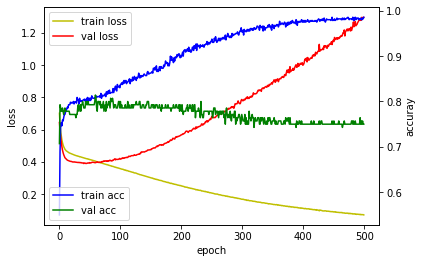

In [11]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

현재 학습 과정 중 가장 낮은 검증셋의 손실값을 가진 모델이 "best_model.h5" 파일로 저장되었습니다.

따라서 이 파일을 로딩하여 모델을 구성한 뒤, 모델에 시험셋을 입력하여 모델 결과를 저장합니다.

시험셋을 입력할 때, 훈련셋에 사용했던 평균(mean)과 표준편차(std)로 정규화시켜야 제대로 추론이 됩니다.

In [12]:
model = load_model("best_model.h5")

x_test -= mean
x_test /= std

y_pred = (model.predict(x_test) > 0.5).astype("int32")
np.savetxt('y_pred.csv', y_pred, fmt='%i')

실제로 모델을 사용할 때는 8개 수치를 벡터로 만들어서 입력하면 됩니다. 각 수치의 의미는 아래와 같으며, 모델을 사용할 때도 입력에 대해 평균(mean)과 표준편차(std)을 이용하여 정규화 시켜야 합니다.

1. 임신 횟수
1. 경구 포도당 내성 검사에서 2시간 동안의 혈장 포도당 농도
1. 이완기 혈압 (mm Hg)
1. 두근 피부 두겹 두께 (mm)
1. 시간 혈청 인슐린 (mu U/ml)
1. 질량 지수
1. 당뇨 직계 가족력
1. 나이 (세)

In [13]:
x_real = [[2., 122., 76., 27., 200., 35.9, 0.483, 26.]]

x_real -= mean
x_real /= std

y_real = model.predict(x_real)

print(y_real)

[[0.2774169]]


출력은 0.0과 1.0 사이의 값으로 나옵니다. 이 수치가 걸릴 실제 확률을 의미하는 것이 아니며, 클래스를 정하기 위해 사용됩니다. 즉 0.5를 기준으로 이상이면 5년 이내에 당뇨병이 걸린다고 예측을 한 것이고, 미만이면 걸리지 않는다고 예측한 것입니다. 